# Asigning trip origins to streets 
assigning trips to the streets based on the occurence

- for each zip code we take the street network
- then we take the the number of trips points per zip code and allocate them to the network


In [1]:
import sys, os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import skmob as skm
import osmnx as ox
import shapely
from random import random
import pickle
# as jupyter notebook cannot find __file__, import module and submodule path via current_folder
current_folder = globals()['_dh'][0]

PROJECT_SRC_PATH = os.path.realpath(os.path.join(current_folder, '..', '..', 'xml4uf'))
sys.path.append(PROJECT_SRC_PATH)

from ufo_map.Utils.helpers import *
from utils.utils import *
from utils.utils_mobility import *

CRS_BOSTON = 26914
CRS_UNI = 4326

## 1) Load Data and plot

In [5]:
# define paths
path_streets = '/Users/felix/Documents/phd/projects/11_xml4uf_global/0_raw_data/bos/streets/bos_streets.csv'
path_trips = '/Users/felix/Documents/phd/1_projects/11_xml4uf_global/data/0_raw_data/bos/mobility/OD0.fma'
path_zips = '/Users/felix/Documents/phd/1_projects/11_xml4uf_global/data/0_raw_data/bos/mobility/BOS.shp'

In [9]:
# load street network
#gdf_streets = import_csv_w_wkt_to_gdf(path_streets,crs=4326)

# read od_data in cleaned version
df = read_od(path_trips)
df = clean_od(df)
# create sample
df = sample_on_p(df)

# read in zip code geoms
gdf_zip = gpd.read_file(path_zips)

In [7]:
df

,origin,destination,p_combined,num_trips
0,100,100,28.872275,29.0
1,100,100100,0.325687,1.0
2,100,100200,0.137299,0.0
3,100,100400,0.208610,0.0
4,100,100500,0.378904,1.0
...,...,...,...,...
190421,985600,91100,0.100048,0.0
190422,985600,92101,0.069182,0.0
190423,985600,981300,0.056410,0.0
190424,985600,981700,0.083018,0.0


In [47]:
set(gdf_streets.highway)

{"['motorway', 'motorway_link']",
 "['motorway', 'trunk']",
 "['primary', 'trunk']",
 "['residential', 'living_street']",
 "['residential', 'road']",
 "['secondary', 'motorway_link']",
 "['secondary', 'primary']",
 "['secondary', 'residential']",
 "['secondary', 'tertiary']",
 "['secondary', 'trunk_link']",
 "['secondary_link', 'secondary']",
 "['tertiary', 'residential']",
 "['tertiary', 'secondary']",
 "['tertiary', 'tertiary_link']",
 "['tertiary', 'unclassified']",
 "['trunk_link', 'primary']",
 "['trunk_link', 'trunk']",
 "['unclassified', 'residential']",
 "['unclassified', 'trunk_link']",
 'busway',
 'living_street',
 'motorway',
 'motorway_link',
 'primary',
 'primary_link',
 'residential',
 'road',
 'secondary',
 'secondary_link',
 'tertiary',
 'tertiary_link',
 'trunk',
 'trunk_link',
 'unclassified'}

In [8]:
# to assign trip points to the streetnetwork we take the zip code with the most origins (852 -> see get_streetnetwork.ipynb)
gdf_zip.loc[gdf_zip.tractid==20303]

,tractid,my_area,geometry
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ..."


In [6]:
gdf_join = gpd.sjoin(gdf_zip.loc[gdf_zip.tractid==20303],gdf_streets,how='inner')
gdf_join

,tractid,my_area,geometry,index_right,osmid,lanes,name,highway,oneway
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",77750,8650375,2,NaN,motorway_link,True
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",77765,325067312,2,Nashua Street,secondary,True
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",145914,288990796,2,Nashua Street,secondary,True
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",77737,482011737,2,Nashua Street,secondary,True
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",80967,138749303,2,NaN,motorway_link,True
...,...,...,...,...,...,...,...,...,...
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",147978,8639232,4,Staniford Street,secondary,False
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",150541,8639232,4,Staniford Street,secondary,False
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",147974,"[533600032, 426456594]","['3', '2']",Cambridge Street,primary,True
894,20303,0.383946,"MULTIPOLYGON (((-71.06916 42.36730, -71.07069 ...",69086,985552044,4,Staniford Street,secondary,False


<AxesSubplot:>

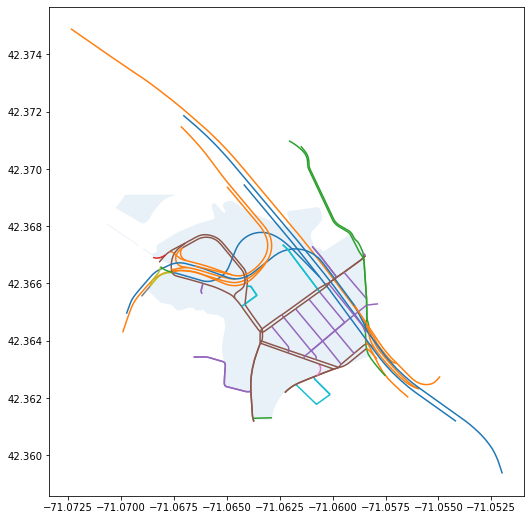

In [7]:
fig,ax = plt.subplots(figsize=(15,9))
gdf_zip.loc[gdf_zip.tractid==20303].plot(ax=ax,alpha=0.1)
gdf_streets.loc[gdf_join.index_right].plot(ax=ax,column='highway')

### 1.1 Remove unwanted street types and cut streets at polygon boundaries of zip_code area

In [49]:
def remove_street_types(gdf_streets, list_bad_types):
    #print('we keep the following types: {}'.format(set(gdf_streets.loc[~gdf_streets.highway.isin(list_bad_types)].highway)))
    return gdf_streets.loc[~gdf_streets.highway.isin(list_bad_types)].reset_index(drop=True)

In [52]:
def get_streets_in_zip(gdf_zip_in, gdf_streets_in, zip_id):
    """gets all street setgements that intersect with the geometry of the zip code
    in:
    gdf_zip_in= gdf with all zip code geoms
    gdf_streets_in = gdf streetnetwork downloaded from osm
    zip_id = zip code id of interest
    returns:
    gdf with streets as linestrings that are inside of the zip code geometry
    """ 

    # get indexes of intersections
    gdf_join = gpd.sjoin(gdf_zip_in.loc[gdf_zip_in.tractid==zip_id],gdf_streets_in,how='inner')
    # get only streetsegments that lie in zip boundary
    return gpd.GeoDataFrame(geometry=list(gdf_streets_in.loc[gdf_join.index_right].unary_union.intersection(gdf_zip_in.loc[gdf_zip_in.tractid==zip_id].unary_union)))

In [142]:
# list unwanted road types
list_unwanted_types = ["['motorway', 'motorway_link']",
 "['motorway', 'trunk']",
 "['primary', 'trunk']",
 "['secondary', 'motorway_link']",
 "['secondary', 'primary']",
 "['secondary', 'trunk_link']",
 "['trunk_link', 'primary']",
 "['trunk_link', 'trunk']",
 "['unclassified', 'trunk_link']",
 'busway',
 'motorway',
 'motorway_link',
 'primary',
 'primary_link',
 'trunk',
 'trunk_link']

# define zip code id
zip_id = 20303

# clean steet types
gdf_streets_cleaned = remove_street_types(gdf_streets,list_unwanted_types)

# cut streets
gdf_streets_cut = get_streets_in_zip(gdf_zip, gdf_streets_cleaned,zip_id)

AttributeError: 'NoneType' object has no attribute 'intersection'

In [18]:
gdf_streets_cleaned

,osmid,lanes,name,highway,oneway,geometry
0,8615227,2,North Avenue,secondary,False,"LINESTRING (-70.94649 42.12862, -70.94626 42.1..."
1,8615227,2,North Avenue,secondary,False,"LINESTRING (-70.94649 42.12862, -70.94687 42.1..."
2,8615580,2,Bates Street,residential,False,"LINESTRING (-70.94649 42.12862, -70.94694 42.1..."
3,8614650,NaN,Groveland Drive,residential,False,"LINESTRING (-70.96801 42.10181, -70.96816 42.1..."
4,8614931,2,Groveland Street,secondary,False,"LINESTRING (-70.96801 42.10181, -70.96788 42.1..."
...,...,...,...,...,...,...
405006,8891395,2,Appleton Street,secondary,False,"LINESTRING (-71.31244 42.63990, -71.31221 42.6..."
405007,683207610,NaN,Appleton Place,residential,True,"LINESTRING (-71.31244 42.63990, -71.31240 42.6..."
405008,8891395,2,Appleton Street,secondary,False,"LINESTRING (-71.31244 42.63990, -71.31246 42.6..."
405009,734503287,2,River Road,secondary,False,"LINESTRING (-71.18839 42.68738, -71.18817 42.6..."


In [55]:
gdf_streets_cut

,geometry
0,"LINESTRING (-71.15842 42.35851, -71.15841 42.3..."
1,"LINESTRING (-71.15817 42.35845, -71.15816 42.3..."
2,"LINESTRING (-71.15298 42.35716, -71.15294 42.3..."
3,"LINESTRING (-71.15363 42.35744, -71.15361 42.3..."
4,"LINESTRING (-71.15474 42.35815, -71.15462 42.3..."
...,...
557,"LINESTRING (-71.14751 42.35576, -71.14752 42.3..."
558,"LINESTRING (-71.14285 42.35565, -71.14374 42.3..."
559,"LINESTRING (-71.14374 42.35568, -71.14410 42.3..."
560,"LINESTRING (-71.14410 42.35496, -71.14414 42.3..."


<AxesSubplot:>

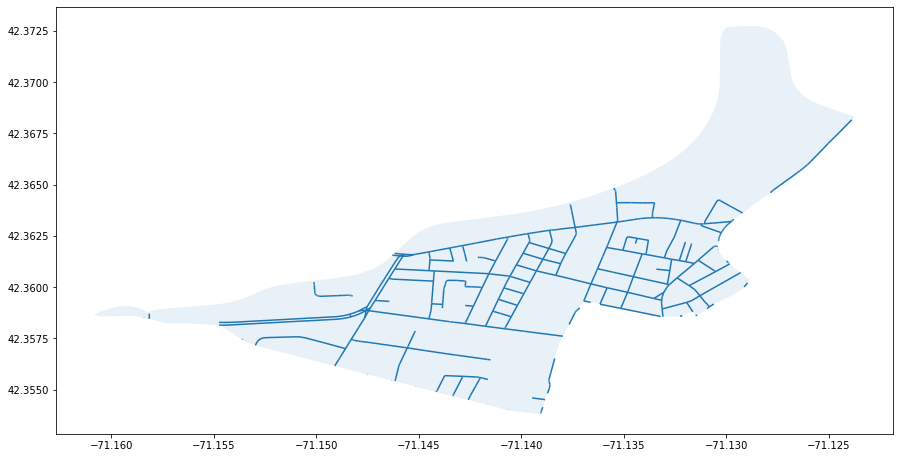

In [56]:
fig,ax = plt.subplots(figsize=(15,9))
gdf_zip.loc[gdf_zip.tractid==zip_id].plot(ax=ax,alpha=0.1)
gdf_streets_cut.plot(ax=ax)

## 2) randomly allocating trips to the street network

In [147]:
# get num trips in zip id
num_trips_zip = df.groupby(['origin']).num_trips.sum().loc[zip_id]
num_trips_zip

656.0

In [75]:
gdf_streets_cut

,geometry
0,"LINESTRING (-71.15842 42.35851, -71.15841 42.3..."
1,"LINESTRING (-71.15817 42.35845, -71.15816 42.3..."
2,"LINESTRING (-71.15298 42.35716, -71.15294 42.3..."
3,"LINESTRING (-71.15363 42.35744, -71.15361 42.3..."
4,"LINESTRING (-71.15474 42.35815, -71.15462 42.3..."
...,...
557,"LINESTRING (-71.14751 42.35576, -71.14752 42.3..."
558,"LINESTRING (-71.14285 42.35565, -71.14374 42.3..."
559,"LINESTRING (-71.14374 42.35568, -71.14410 42.3..."
560,"LINESTRING (-71.14410 42.35496, -71.14414 42.3..."


In [113]:
gdf_streets_cut = gdf_streets_cut.set_crs(4326)
gdf_streets_cut.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [119]:
gdf_streets

,osmid,lanes,name,highway,oneway,geometry
0,8615227,2,North Avenue,secondary,False,"LINESTRING (-70.94649 42.12862, -70.94626 42.1..."
1,8615227,2,North Avenue,secondary,False,"LINESTRING (-70.94649 42.12862, -70.94687 42.1..."
2,8615580,2,Bates Street,residential,False,"LINESTRING (-70.94649 42.12862, -70.94694 42.1..."
3,8614650,NaN,Groveland Drive,residential,False,"LINESTRING (-70.96801 42.10181, -70.96816 42.1..."
4,8614931,2,Groveland Street,secondary,False,"LINESTRING (-70.96801 42.10181, -70.96788 42.1..."
...,...,...,...,...,...,...
426400,8891395,2,Appleton Street,secondary,False,"LINESTRING (-71.31244 42.63990, -71.31221 42.6..."
426401,683207610,NaN,Appleton Place,residential,True,"LINESTRING (-71.31244 42.63990, -71.31240 42.6..."
426402,8891395,2,Appleton Street,secondary,False,"LINESTRING (-71.31244 42.63990, -71.31246 42.6..."
426403,734503287,2,River Road,secondary,False,"LINESTRING (-71.18839 42.68738, -71.18817 42.6..."


In [130]:
# transform to meters
gdf_streets_cut = gdf_streets_cut.to_crs(2806)
# calculate meters 
gdf_streets_cut['lenght'] = gdf_streets_cut.length
# calculate percentage of overall streetnetwork lenght in zip (which is 17746.75 m)
gdf_streets_cut['percentage'] = gdf_streets_cut.length/gdf_streets_cut.lenght.sum()
gdf_streets_cut = gdf_streets_cut.to_crs(4326)
    

In [96]:
def assign_point_2_line(street_index):
    # randomly allocates a point on a line
    # lets take one linestring
    line = gdf_streets_cut.geometry.iloc[street_index]
    # lets generate a random point
    return line.interpolate(random(), True)


In [100]:
s = gpd.GeoSeries(pt)

<AxesSubplot:>

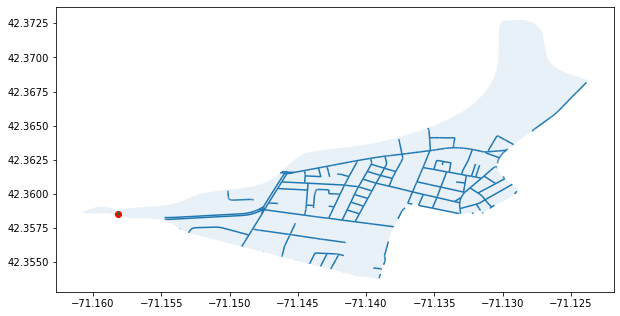

In [131]:
fig,ax = plt.subplots(figsize=(10,10))
gdf_zip.loc[gdf_zip.tractid==zip_id].plot(ax=ax,alpha=0.1)
gdf_streets_cut.plot(ax=ax)
gdf_streets_cut.iloc[[1]].geometry.plot(ax=ax,color='green')
s.plot(ax=ax,color='red')

In [92]:
type(pt

shapely.geometry.point.Point

### 2.1 different approach with network graph.

In [143]:
# we import it from other jupyter nb
# getting osm street data 
g = ox.graph_from_polygon(gdf_zip.loc[gdf_zip.tractid==zip_id].geometry.iloc[0],simplify=True,network_type='drive')
g

In [149]:
# sample points randomly on whole network
points = gpd.GeoDataFrame({'geometry':ox.utils_geo.sample_points(g,int(num_trips_zip))}).reset_index(drop=True)
points

/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")
/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'interpolate' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  return lines.interpolate(np.random.rand(n), normalized=True)


,geometry
0,POINT (-71.05998 42.36513)
1,POINT (-71.06512 42.36599)
2,POINT (-71.06604 42.36650)
3,POINT (-71.06042 42.36552)
4,POINT (-71.06201 42.36454)
...,...
651,POINT (-71.06207 42.36508)
652,POINT (-71.06358 42.36648)
653,POINT (-71.05838 42.36487)
654,POINT (-71.06440 42.36670)


In [145]:
gdf_streets = ox.utils_graph.graph_to_gdfs(g, 
                                       nodes=False, 
                                       edges=True,
                                       node_geometry=False, 
                                       fill_edge_geometry=True)

<AxesSubplot:>

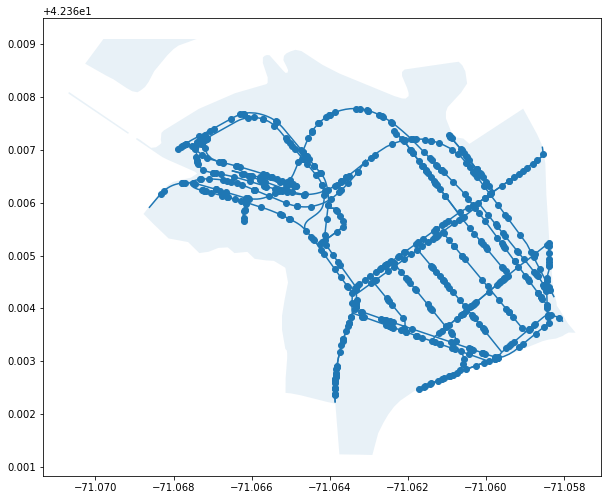

In [150]:
fig,ax = plt.subplots(figsize=(10,10))
gdf_zip.loc[gdf_zip.tractid==zip_id].plot(ax=ax,alpha=0.1)
gdf_streets.plot(ax=ax)
#gdf_streets_cut.iloc[[1]].geometry.plot(ax=ax,color='green')
#s.plot(ax=ax,color='red')
points.plot(ax=ax)

## 3) how can we do this for the whole graph?!
the issue with the solution above is that we don't want to download the graph for each segment and then allocate points.    
    

[x] Instead we want to download the graph once...and then allocate the points   
[ ] Still open: remve unwanted street types from graph network!


### 3.1 Load Graph via pickle

In [4]:
def get_graph(path_graph):
    "loads graph file via pickle so that we can calculate graph functions"
    with open(path_graph, 'rb') as f: 
        g_nx = pickle.load(f)
    return g_nx

In [5]:
G = get_graph('/Users/felix/Documents/phd/projects/11_xml4uf_global/0_raw_data/bos/streets/bos_graph_full.pickle')

In [6]:
# get nodes from graph
nodes = ox.graph_to_gdfs(G, edges=False)

### 3.2 allocate trips randomly on sub_graphs 

In [9]:
# dummy test set of zip codes
gdf_zip_dummy = gdf_zip.iloc[0:5]
gdf_zip_dummy 

,tractid,my_area,geometry
0,630400,9.988907,"POLYGON ((-71.35236 41.93142, -71.35281 41.931..."
1,631100,8.289611,"POLYGON ((-71.35281 41.93117, -71.35236 41.931..."
2,631300,8.960974,"POLYGON ((-71.29017 41.94444, -71.29021 41.944..."
3,631200,17.019618,"POLYGON ((-71.30786 41.96025, -71.30804 41.959..."
4,631400,0.790492,"POLYGON ((-71.29125 41.94414, -71.29094 41.944..."


In [10]:
# convert to meter crs
nodes_crs = nodes.to_crs(CRS_BOSTON)
gdf_zip_dummy_crs = gdf_zip_dummy.to_crs(CRS_BOSTON)
G_crs = ox.project_graph(G, to_crs=CRS_BOSTON)

In [149]:
class OD_Allocator():
    
    def __init__(self):
        self.g = None
        self.nodes = None
        self.gdf_zip = None
        self.df_od = None
        self.gdf_points_o = None
        self.gdf_points_d = None

    def num_points_per_zip(self,locx,idx):
        # get number of points per zip code
        return self.df_od.groupby([locx]).num_trips.sum().loc[idx]

    def assign_points_random(self, gdf_zip_polygon, num_trips,locx):
        """
        function to allocate points in a subpart of networkx graph g
        in:
        - g: networkx graph of a whole city
        - gdf_zip_polygon: polygon geometry of zip code 
        - num_points: integer number of points (trips) starting or ending in zip code area

        returns:
        - gdf with point geometries
        """
        # calculate intersection (Note: add this point all geoms have to be in meter crs)
        intersecting_nodes = self.nodes[self.nodes.intersects(gdf_zip_polygon)].index
        
        # create sub_graph
        g_sub = self.g.subgraph(intersecting_nodes)

        # sample points on subgraph network
        return gpd.GeoDataFrame({'geometry_'+locx:ox.utils_geo.sample_points(g_sub,int(num_trips))}).reset_index(drop=True)
    
    def allocate_per_zip(self,loc1):
       
        # intialise trip gdf!
        gdf = gpd.GeoDataFrame()
        
        # define endings
        if loc1 == 'origin': loc2 = 'destination'
        else: loc2 = 'origin' 

        # iterate over all zip code ids and allocate points
        for i, id in enumerate(self.gdf_zip.tractid):
            print('part {} of {}; id: {}'.format(i,len(self.gdf_zip),id))

            if id in list(self.df_od[loc1]):
                print('get num points per zip')
                # get number of points per zip code
                num_points = self.num_points_per_zip(loc1,id)

                print('get tractids for non zeros')
                # get loc2 tractids for the non zero trips
                l = [[self.df_od.loc[(self.df_od[loc1]==id)&(self.df_od.num_trips!=0)][loc2].iloc[i]]*el for i,el in enumerate(self.df_od.loc[(self.df_od[loc1]==id)&(self.df_od.num_trips!=0)].num_trips.astype(int))]

                print('create flat list')
                # create flat list
                dest_id = [item for sublist in l for item in sublist]

                print('get points per zip')
                # allocate trips
                gdf_points_zip = self.assign_points_random(self.gdf_zip.loc[self.gdf_zip.tractid==id].geometry.iloc[0],num_points,loc1)
                gdf_points_zip['tractid'] = id
                gdf_points_zip['id_'+loc2] = dest_id

                # add to overall
                gdf = pd.concat([gdf,gdf_points_zip])

        return gdf.reset_index(drop=True)  


    def find_od_pairs(self):
        # create common id col of id_origin+id_dest
        self.gdf_points_o['id']=(self.gdf_points_o.tractid.astype(str)+self.gdf_points_o.id_destination.astype(str)).astype(int)
        self.gdf_points_d['id']=(self.gdf_points_d.id_origin.astype(str)+self.gdf_points_d.tractid.astype(str)).astype(int)

        self.gdf_points_o['key'] = self.gdf_points_o.groupby('id').cumcount()
        self.gdf_points_d['key'] = self.gdf_points_d.groupby('id').cumcount()
        self.gdf_points = self.gdf_points_o.merge(self.gdf_points_d, on=['id', 'key'])
        self.gdf_points = self.gdf_points[['id_origin','id_destination','geometry_origin','geometry_destination']]

        # calculating the number of trips where we cannot recreate a o-d pair (f.e. should be 0)
        num_loss_o = len(self.gdf_points_o)-len(self.gdf_points)
        num_loss_d = len(self.gdf_points_d)-len(self.gdf_points)
        print('when merging, we loose {} trips from origin and {} from destination'.format(num_loss_o,num_loss_d))

In [150]:
# 
p = OD_Allocator()

# assign to class
p.df_od = df
p.g = G_crs
p.nodes = nodes_crs
p.gdf_zip = gdf_zip_dummy_crs

p.gdf_points_o = p.allocate_per_zip('origin')
p.gdf_points_d = p.allocate_per_zip('destination')

p.find_od_pairs()

part 0 of 5; id: 630400
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 1 of 5; id: 631100
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 2 of 5; id: 631300
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 3 of 5; id: 631200
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 4 of 5; id: 631400
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 0 of 5; id: 630400
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 1 of 5; id: 631100
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 2 of 5; id: 631300
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 3 of 5; id: 631200
get num points per zip
get tractids for non zeros
create flat list
get points per zip


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


part 4 of 5; id: 631400
get num points per zip
get tractids for non zeros
create flat list
get points per zip
when merging, we loose 701 trips from origin and 613 from destination


/opt/miniconda3/envs/xml4uf/lib/python3.10/site-packages/osmnx/utils_geo.py:45: UserWarning: graph should be undirected to not oversample bidirectional edges
  warnings.warn("graph should be undirected to not oversample bidirectional edges")


In [48]:
len(p.gdf_points_o.loc[(p.gdf_points_o.id_destination==630400)&(p.gdf_points_o.tractid==630400)])

58

## 3.3. merge created origin and destination point geoms to have an o-d gdf

In [52]:
# first batch with same origin and destination
gdf_same_o = p.gdf_points_o.loc[p.gdf_points_o.tractid==p.gdf_points_o['id_destination']].reset_index(drop=True)
gdf_same_d = p.gdf_points_d.loc[p.gdf_points_d.tractid==p.gdf_points_d['id_origin']].reset_index(drop=True)

gdf_same = pd.concat([gdf_same_o,gdf_same_d],axis=1)
print(gdf_same.head())
print('check lenght of same same:',len(gdf_same.loc[gdf_same.id_origin==630400]))

gdf_dif_o = p.gdf_points_o.loc[p.gdf_points_o.tractid!=p.gdf_points_o['id_destination']].reset_index(drop=True)
gdf_dif_d = p.gdf_points_d.loc[p.gdf_points_d.tractid!=p.gdf_points_d['id_origin']].reset_index(drop=True)


                 geometry_origin  tractid  id_destination  \
0  POINT (433126.507 107959.290)   630400          630400   
1  POINT (432110.422 106763.338)   630400          630400   
2  POINT (431390.023 107996.326)   630400          630400   
3  POINT (430474.849 104968.341)   630400          630400   
4  POINT (431550.511 106894.207)   630400          630400   

            geometry_destination  tractid  id_origin  
0  POINT (429626.145 105026.270)   630400     630400  
1  POINT (432772.956 107808.611)   630400     630400  
2  POINT (430470.014 106166.610)   630400     630400  
3  POINT (430504.665 106414.428)   630400     630400  
4  POINT (430599.517 104881.049)   630400     630400  
check lenght of same same: 58


In [81]:
# reindex
p.gdf_points_d = p.gdf_points_d.reindex(index=p.gdf_points_o['tractid'])
# reset_index
p.gdf_points_d = p.gdf_points_d.reset_index()
p.gdf_points_d

,geometry_origin,tractid,id_destination
0,POINT (432924.218 107232.766),630400,201
1,POINT (428321.546 105121.499),630400,301
2,POINT (431301.891 108275.646),630400,320102
3,POINT (431244.774 108058.219),630400,368200
4,POINT (431208.948 107111.853),630400,383700
...,...,...,...
175,POINT (435380.708 104869.650),631400,631800
176,POINT (435540.726 104832.872),631400,631800
177,POINT (435620.363 105253.994),631400,631800
178,POINT (434795.712 105350.382),631400,631800


In [99]:
p.gdf_points_d

,geometry_destination,tractid,id_origin
0,POINT (431952.285 107320.936),630400,100500
1,POINT (428783.833 104419.401),630400,20303
2,POINT (430810.783 106927.420),630400,250100
3,POINT (430275.441 104942.857),630400,374800
4,POINT (432770.292 107747.760),630400,402400
...,...,...,...
1305,POINT (434761.125 105529.638),631400,631800
1306,POINT (435328.436 105002.397),631400,631800
1307,POINT (435319.745 104821.377),631400,631800
1308,POINT (434614.987 105259.664),631400,749100


In [ ]:
def find_od_pairs(self):
    # create common id col of id_origin+id_dest
    self.gdf_points_o['id']=(self.gdf_points_o.tractid.astype(str)+self.gdf_points_o.id_destination.astype(str)).astype(int)
    self.gdf_points_d['id']=(self.gdf_points_d.id_origin.astype(str)+self.gdf_points_d.tractid.astype(str)).astype(int)

    self.gdf_points_o['key'] = self.gdf_points_o.groupby('id').cumcount()
    self.gdf_points_d['key'] = self.gdf_points_d.groupby('id').cumcount()
    self.gdf_points = self.gdf_points_o.merge(self.gdf_points_d, on=['id', 'key'])
    self.gdf_points = self.gdf_points[['id_origin','id_destination','geometry_origin','geometry_destination']]

    # calculating the number of trips where we cannot recreate a o-d pair (f.e. should be 0)
    num_loss_o = len(self.gdf_points_o)-len(self.gdf_points)
    num_loss_d = len(self.gdf_points_d)-len(self.gdf_points)
    print('when merging, we loose {} trips from origin and {} from destination'.format(num_loss_o,num_loss_d))

<AxesSubplot:>

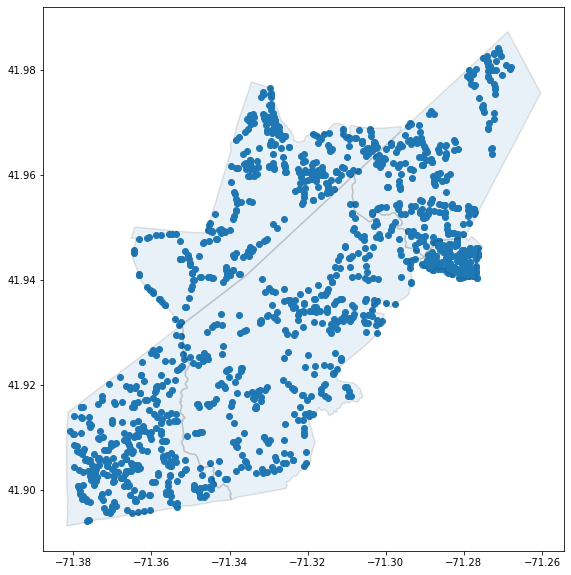

In [190]:
# plot graph
fig, ax = plt.subplots(figsize=(10,10))
gdf_zip_dummy.plot(ax=ax,alpha=0.1)
gdf_zip_dummy.exterior.plot(ax=ax,alpha=0.1,color='black')
gdf_trips.plot(ax=ax)

#gdf_zip.loc[gdf_zip.tractid==zip_id].plot(ax=ax,alpha=0.1)
#gdf_G_sub.plot(ax=ax)
#gdf_streets_cut.iloc[[1]].geometry.plot(ax=ax,color='green')
#s.plot(ax=ax,color='red')
#points.plot(ax=ax)

## 4 Debugg and understand warning undirected edges

In [11]:
g = get_graph('/Users/felix/Documents/phd/1_projects/11_xml4uf_global/data/0_raw_data/bos/streets/old/bos_graph_filtered.pickle')

gdf_zip = gpd.read_file('/Users/felix/Documents/phd/1_projects/11_xml4uf_global/data/0_raw_data/bos/mobility/BOS.shp').to_crs(CRS_BOSTON)

# get nodes of full graph
nodes = get_nodes(g)

### 4.1 with warning

In [18]:
def allocate_p(nodes, g, num_trips = 10, locx='origin', id = gdf_zip.tractid.iloc[0]):

    print(id)
    gdf_zip_polygon = gdf_zip.loc[gdf_zip.tractid==id].geometry.iloc[0]

    # calculate intersection (Note: add this point all geoms have to be in meter crs)
    intersecting_nodes = nodes[nodes.intersects(gdf_zip_polygon)].index

    # create sub_graph
    g_sub = g.subgraph(intersecting_nodes)

    # get undirected graph
    g_sub = ox.utils_graph.get_undirected(g_sub)

    # sample points on subgraph network
    return gpd.GeoDataFrame({'geometry_'+locx:ox.utils_geo.sample_points(g_sub,int(num_trips))}).reset_index(drop=True), g_sub

In [19]:
gdf, g_sub = allocate_p(nodes,g)
gdf

630400


,geometry_origin
0,POINT (2798557.249 5030030.679)
1,POINT (2799260.210 5030540.782)
2,POINT (2799139.294 5032711.582)
3,POINT (2798661.892 5032530.109)
4,POINT (2798505.701 5030113.713)
5,POINT (2799057.060 5034095.143)
6,POINT (2798761.329 5032721.812)
7,POINT (2799452.741 5033605.799)
8,POINT (2797700.871 5030490.751)
9,POINT (2799627.185 5033195.040)


In [20]:
gdf_sub = nxg_to_gdf(g_sub)
gdf=gdf.rename(columns={'geometry_origin':'geometry'})


<AxesSubplot:>

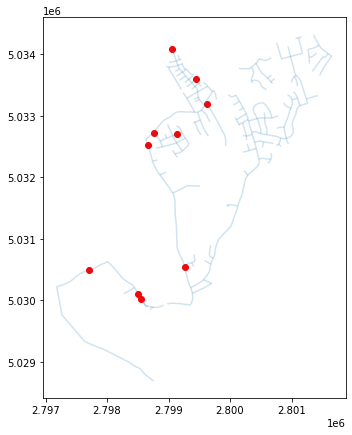

In [21]:
fig,ax = plt.subplots(figsize=(7,7))
gdf_sub.plot(ax=ax, alpha=0.2)
gdf.plot(ax=ax,color='red')

### 4.2. without warning

In [17]:
g2 = ox.utils_graph.get_undirected(g)

In [18]:
# get nodes of full graph
nodes2 = get_nodes(g2)

In [19]:
num_trips = 10
locx='origin'
id = gdf_zip.tractid.iloc[0]
print(id)
gdf_zip_polygon = gdf_zip.loc[gdf_zip.tractid==id].geometry.iloc[0]

# calculate intersection (Note: add this point all geoms have to be in meter crs)
intersecting_nodes = nodes2[nodes2.intersects(gdf_zip_polygon)].index

# create sub_graph
g_sub2 = g2.subgraph(intersecting_nodes)

# sample points on subgraph network
gdf2 = gpd.GeoDataFrame({'geometry_'+locx:ox.utils_geo.sample_points(g_sub2,int(num_trips))}).reset_index(drop=True)

630400


In [21]:
gdf_sub2 = nxg_to_gdf(g_sub2)
gdf2=gdf2.rename(columns={'geometry_origin':'geometry'})

<AxesSubplot:>

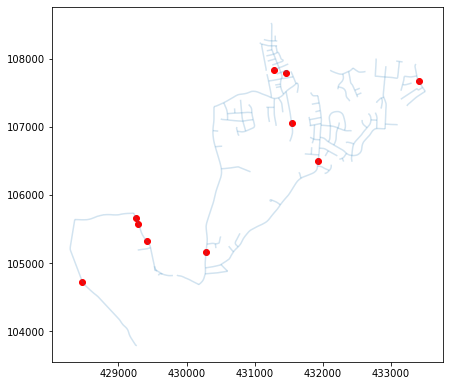

In [22]:
fig,ax = plt.subplots(figsize=(7,7))
gdf_sub2.plot(ax=ax, alpha=0.2)
gdf2.plot(ax=ax,color='red')

## 5 Debugg: subgrah without edges

In [40]:
g = get_graph('/Users/felix/Documents/phd/1_projects/11_xml4uf_global/0_raw_data/bos/streets/bos_graph_filtered.pickle')

gdf_zip = gpd.read_file('/Users/felix/Documents/phd/1_projects/11_xml4uf_global/0_raw_data/bos/mobility/BOS.shp').to_crs(CRS_BOSTON)

# get nodes of full graph
nodes = get_nodes(g)

In [25]:
def allocate_p(nodes, g, num_trips = 10, locx='origin', id = gdf_zip.tractid.iloc[0]):

    print(id)
    gdf_zip_polygon = gdf_zip.loc[gdf_zip.tractid==id].geometry.iloc[0]

    # calculate intersection (Note: add this point all geoms have to be in meter crs)
    intersecting_nodes = nodes[nodes.intersects(gdf_zip_polygon)].index

    # create sub_graph
    g_sub = g.subgraph(intersecting_nodes)

    return g_sub
    # get undirected graph
    #g_sub = ox.utils_graph.get_undirected(g_sub)

    # sample points on subgraph network
    #return gpd.GeoDataFrame({'geometry_'+locx:ox.utils_geo.sample_points(g_sub,int(num_trips))}).reset_index(drop=True)

In [43]:
g_sub1=allocate_p(nodes,g,10,'origin',201100)
g_sub2=allocate_p(nodes,g,10,'origin',206900)

201100


In [44]:
list(g_sub1.edges())

[]

## 6 presentation: subgraph vs normal graph

In [54]:
path_filtered = '/Users/felix/cluster_remote/p/projects/eubucco/other_projects/urbanformvmt_global/data/0_raw_data/bos/streets/bos_graph_filtered.pickle'
path_full = '/Users/felix/cluster_remote/p/projects/eubucco/other_projects/urbanformvmt_global/data/0_raw_data/bos/streets/bos_graph_full.pickle'

g = get_graph(path_filtered)
g_full = get_graph(path_full)

gdf_zip = gpd.read_file('/Users/felix/Documents/phd/1_projects/11_xml4uf_global/data/0_raw_data/bos/mobility/BOS.shp').to_crs(CRS_BOSTON)

# get nodes of full graph
nodes_sub = get_nodes(g)
nodes_full = get_nodes(g_full)

In [56]:
gdf, g_filt = allocate_p(nodes_sub,g)
gdf_filt = nxg_to_gdf(g_filt)
gdf=gdf.rename(columns={'geometry_origin':'geometry'})

gdf_2, g_full = allocate_p(nodes_full,g_full)
gdf_full = nxg_to_gdf(g_full)


630400
630400


<AxesSubplot:>

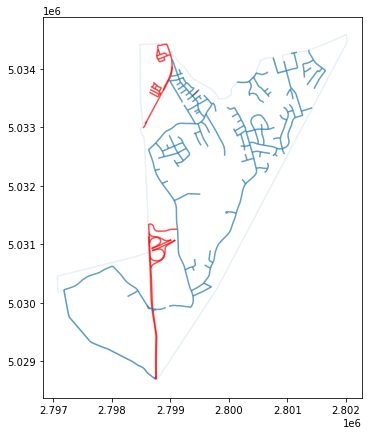

In [70]:
fig,ax = plt.subplots(figsize=(7,7))
gdf_zip.iloc[[0]].exterior.plot(ax=ax,alpha=0.1)
gdf_full.loc[~gdf_full.osmid.isin(gdf_sub.osmid)].plot(ax=ax, alpha=0.7,color='red')
gdf_sub.plot(ax=ax, alpha=0.7)
#gdf.plot(ax=ax,color='red')

<AxesSubplot:>

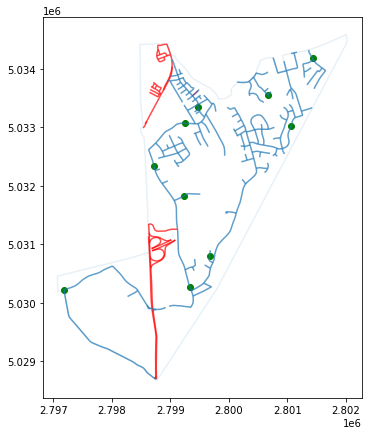

In [71]:
fig,ax = plt.subplots(figsize=(7,7))
gdf_zip.iloc[[0]].exterior.plot(ax=ax,alpha=0.1)
gdf_full.loc[~gdf_full.osmid.isin(gdf_sub.osmid)].plot(ax=ax, alpha=0.7,color='red')
gdf_sub.plot(ax=ax, alpha=0.7)
gdf.plot(ax=ax,color='green')

In [74]:
gdf_full_cut = gdf_full.loc[gdf_full.osmid.isin(gdf_sub.osmid)]
set(gdf_full_cut.highway)

{'residential', 'secondary', 'tertiary'}